In [1]:
from ebisu import *
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
def mkPosterior(prior, successes, total, tnow, tback):
    (alpha, beta, t) = prior
    dt = tnow / t
    et = tback / tnow
    binomlns = [binomln(total - successes, i) for i in range(total - successes + 1)]

    signs = [(-1)**i for i in range(total - successes + 1)]
    logDenominator = logsumexp([
        binomlns[i] + betaln(beta, alpha + dt * (successes + i))
        for i in range(total - successes + 1)
    ],
                               b=signs) + np.log(dt * et)
    logPdf = lambda logp: logsumexp([
        binomlns[i] + logp * ((alpha + dt * (successes + i)) / (dt * et) - 1) +
        (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)
    ],
                                    b=signs) - logDenominator
    return logPdf


def compare(prior, successes, total, tnow, tback, viz=True):
    m1 = updateRecall(prior, successes, total, tnow, tback=tback, rebalance=False)

    p1 = np.vectorize(mkPosterior(prior, successes, total, tnow, tback=tback))
    from scipy.stats import beta as betarv
    from scipy.integrate import trapz

    ps = np.linspace(0, 1, 5000)
    pdf = np.exp(p1(np.log(ps)))

    betapdf = betarv.pdf(ps, m1[0], m1[1])
    err = trapz(np.abs(pdf - betapdf), ps)

    if viz:
        integrals = [trapz(pdf, ps), trapz(betapdf, ps)]

        fig, ax = plt.subplots(1, 2)
        ax[0].plot(ps, pdf, ps, betapdf)
        ax[0].set_title('PDF (tback={:0.4g})'.format(tback))
        ax[0].legend(['posterior', 'beta fit'])
        ax[0].set_xlabel('probability')

        ax[1].plot(ps, pdf - betapdf)
        ax[1].set_title('error={:0.3g}'.format(err))
        ax[1].set_xlabel('probability')
    else:
        integrals = 'skipped'

    ret = dict(err=err, m1=m1, p1=p1, integrals=integrals)
    return ret



<ipython-input-2-e8f34a6ae0fd>:29: RuntimeWarning: divide by zero encountered in log
  pdf = np.exp(p1(np.log(ps)))
<ipython-input-2-e8f34a6ae0fd>:15: RuntimeWarning: divide by zero encountered in log
  (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)
<ipython-input-2-e8f34a6ae0fd>:29: RuntimeWarning: divide by zero encountered in log
  pdf = np.exp(p1(np.log(ps)))
<ipython-input-2-e8f34a6ae0fd>:15: RuntimeWarning: divide by zero encountered in log
  (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)
<ipython-input-2-e8f34a6ae0fd>:29: RuntimeWarning: divide by zero encountered in log
  pdf = np.exp(p1(np.log(ps)))
<ipython-input-2-e8f34a6ae0fd>:15: RuntimeWarning: divide by zero encountered in log
  (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)


[{'err': 3.853139606141044e-12, 'm1': (153.300000001185, 4.400000000033856, 1.0), 'p1': <numpy.vectorize object at 0x115956040>, 'integrals': [1.0000000001232494, 1.0000000001232199]}, {'err': 0.007779272102140763, 'm1': (4.545908366321882, 4.545908366319766, 26.44452526874831), 'p1': <numpy.vectorize object at 0x118a289d0>, 'integrals': [1.0000000000000286, 1.0000000000000002]}, {'err': 0.007779272101993315, 'm1': (4.545908366310423, 4.545908366310375, 26.44452526875782), 'p1': <numpy.vectorize object at 0x118b034c0>, 'integrals': [1.000000000000029, 1.0]}]


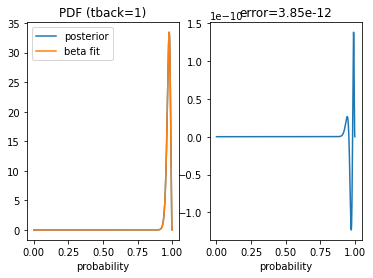

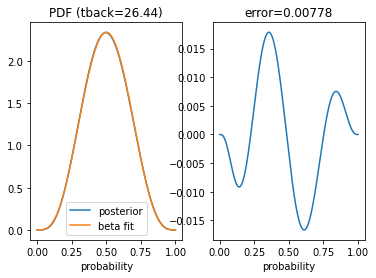

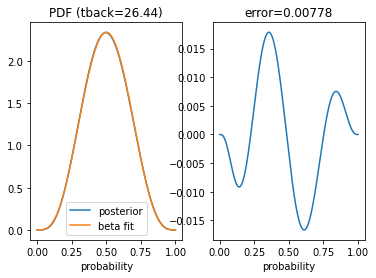

In [3]:

pre1 = (3.3, 4.4, 1.)

# surprise 1: got all right long after halflife
k = 3
n = 3
tnow = 50.
hlCoarse = updateRecall(pre1, k, n, tnow)[2]
hl = modelToPercentileDecay(updateRecall(pre1, k, n, tnow))

resOrig = compare(pre1, k, n, tnow, 1.)
resCoarse = compare(pre1, k, n, tnow, hlCoarse)
resHl = compare(pre1, k, n, tnow, hl)

print([resOrig, resCoarse, resHl])


<ipython-input-2-e8f34a6ae0fd>:29: RuntimeWarning: divide by zero encountered in log
  pdf = np.exp(p1(np.log(ps)))
<ipython-input-2-e8f34a6ae0fd>:15: RuntimeWarning: divide by zero encountered in log
  (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)
<ipython-input-2-e8f34a6ae0fd>:29: RuntimeWarning: divide by zero encountered in log
  pdf = np.exp(p1(np.log(ps)))
<ipython-input-2-e8f34a6ae0fd>:15: RuntimeWarning: divide by zero encountered in log
  (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)
<ipython-input-2-e8f34a6ae0fd>:29: RuntimeWarning: divide by zero encountered in log
  pdf = np.exp(p1(np.log(ps)))
<ipython-input-2-e8f34a6ae0fd>:15: RuntimeWarning: divide by zero encountered in log
  (beta - 1) * np.log(1 - np.exp(logp / (et * dt))) for i in range(total - successes + 1)


[{'err': 0.014928233285779299, 'm1': (2.5026825116846645, 7.91107740684479, 1.0), 'p1': <numpy.vectorize object at 0x118f205b0>, 'integrals': [1.0000000000289997, 0.9999999976834908]}, {'err': 0.007633903143508347, 'm1': (7.066129257084665, 7.066128416603545, 0.46011436429577746), 'p1': <numpy.vectorize object at 0x118a28970>, 'integrals': [0.9999999999977238, 0.9999999999999998]}]


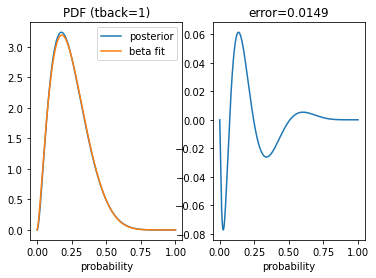

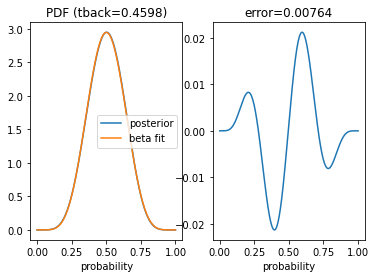

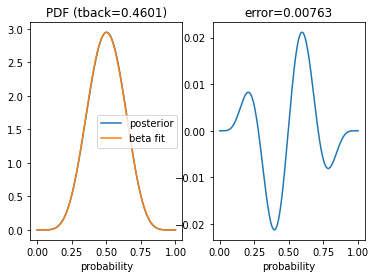

In [4]:
# surprise 2: got all wrong far before halflife
k = 0
n = 3
tnow = 1/10.
hlCoarse = updateRecall(pre1, k, n, tnow)[2]
hl = modelToPercentileDecay(updateRecall(pre1, k, n, tnow))

resOrig = compare(pre1, k, n, tnow, 1.)
resCoarse = compare(pre1, k, n, tnow, hlCoarse)
resHl = compare(pre1, k, n, tnow, hl)

print([resOrig, resHl])
